## Introduction

This tutorial is a brief introduction to music generation using **Generative Adversarial Networks** (**GAN**s). 

The goal of this tutorial is to train a machine learning model using a dataset of Bach compositions so that the model learns to add accompaniments to a single track input melody. In other words, if the user provides a single piano track of a song such as "twinkle twinkle little star", the GAN model would add three other piano tracks to make the music sound more Bach-inspired.

The proposed algorithm consists of two competing networks: a generator and a critic (discriminator). A generator is a deep neural network that learns to create new synthetic data that resembles the distribution of the dataset on which it was trained. A critic is another deep neural network that is trained to differentiate between real and synthetic data. The generator and the critic are trained in alternating cycles such that the generator learns to produce more and more realistic data (Bach-like music in this use case) while the critic iteratively gets better at learning to differentiate real data (Bach music) from the synthetic ones.

As a result, the quality of music produced by the generator gets more and more realistic with time.

![High level WGAN-GP architecture](images/dgan.png "WGAN-GP architecture")

## Dependencies
First, let's import all of the python packages we will use throughout the tutorial.


In [ ]:
# Copyright 2019 Amazon.com, Inc. or its affiliates. All Rights Reserved.

# Permission is hereby granted, free of charge, to any person obtaining a copy of
# this software and associated documentation files (the "Software"), to deal in
# the Software without restriction, including without limitation the rights to
# use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of
# the Software, and to permit persons to whom the Software is furnished to do so.

# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS
# FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR
# COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER
# IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN
# CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.


# Create the environment
import subprocess
print("Please wait, while the required packages are being installed...")
subprocess.call(['requirements.sh'])
print("All the required packages are installed successfully...")

In [ ]:
!source activate python3
#!conda update --all --y 
!pip install tensorflow-gpu==1.14.0
!pip install numpy==1.16.4
!pip install pretty_midi
!pip install pypianoroll
!pip install music21
!pip install seaborn
!pip install --ignore-installed moviepy

In [1]:
# IMPORTS
import os 
import numpy as np
from PIL import Image
import logging
import pypianoroll
import scipy.stats
import pickle
import music21
from IPython import display
import matplotlib.pyplot as plt

# Configure Tensorflow
import tensorflow as tf
print(tf.__version__)
tf.logging.set_verbosity(tf.logging.ERROR)
tf.enable_eager_execution()

# Use this command to make a subset of GPUS visible to the jupyter notebook.
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"

# Utils library for plotting, loading and saving midi among other functions
from utils import display_utils, metrics_utils, path_utils, inference_utils, midi_utils

LOGGER = logging.getLogger("gan.train")
%matplotlib inline

1.14.0


## Configuration

Here we configure paths to retrieve our dataset and save our experiments.

In [10]:
root_dir = './Experiments'

# Directory to save checkpoints
model_dir = os.path.join(root_dir,'2Bar')    # JSP: 229, Bach: 19199

# Directory to save pianorolls during training
train_dir = os.path.join(model_dir, 'train')

# Directory to save checkpoint generated during training
check_dir = os.path.join(model_dir, 'preload')

# Directory to save midi during training
sample_dir = os.path.join(model_dir, 'sample')

# Directory to save samples generated during inference
eval_dir = os.path.join(model_dir, 'eval')

os.makedirs(train_dir, exist_ok=True)
os.makedirs(eval_dir, exist_ok=True)
os.makedirs(sample_dir, exist_ok=True)


## Data Preparation

### Dataset summary

In this tutorial, we use the [`JSB-Chorales-dataset`](http://www-etud.iro.umontreal.ca/~boulanni/icml2012), comprising 229 chorale snippets. A chorale is a hymn that is usually sung with a single voice playing a simple melody and three lower voices providing harmony. In this dataset, these voices are represented by four piano tracks.

Let's listen to a song from this dataset.

In [11]:
display_utils.playmidi('./original_midi/MIDI-0.mid')

### Data format - piano roll

For the purpose of this tutorial, we represent music from the JSB-Chorales dataset in the piano roll format.

**Piano roll** is a discrete representation of music which is intelligible by many machine learning algorithms. Piano rolls can be viewed as a two-dimensional grid with "Time" on the horizontal axis and "Pitch" on the vertical axis. A one or zero in any particular cell in this grid indicates if a note was played or not at that time for that pitch.

Let us look at a few piano rolls in our dataset. In this example, a single piano roll track has 32 discrete time steps and 128 pitches. We see four piano rolls here, each one representing a separate piano track in the song.

<img src="images/pianoroll2.png" alt="Dataset summary" width="800">

You might notice this representation looks similar to an image. While the sequence of notes is often the natural way that people view music, many modern machine learning models instead treat music as images and leverage existing techniques within the computer vision domain. You will see such techniques used in our architecture later in this tutorial.

**Why 32 time steps?**

For the purpose of this tutorial, we sample two non-empty bars (https://en.wikipedia.org/wiki/Bar_(music)) from each song in the JSB-Chorales dataset. A **bar** (or **measure**) is a unit of composition and contains four beats for songs in our particular dataset (our songs are all in 4/4 time) :

We’ve found that using a resolution of four time steps per beat captures enough of the musical detail in this dataset.

This yields...

$$ \frac{4\;timesteps}{1\;beat} * \frac{4\;beats}{1\;bar} * \frac{2\;bars}{1} = 32\;timesteps $$

Let us now load our dataset as a numpy array. Our dataset comprises 229 samples of 4 tracks (all tracks are piano). Each sample is a 32 time-step snippet of a song, so our dataset has a shape of...
(num_samples, time_steps, pitch_range, tracks) = (229, 32, 128, 4).

In [6]:
training_data = np.load('./dataset/train.npy')
print(training_data.shape)

(229, 32, 128, 4)


Let's see a sample of the data we'll feed into our model. The four graphs represent the four tracks.

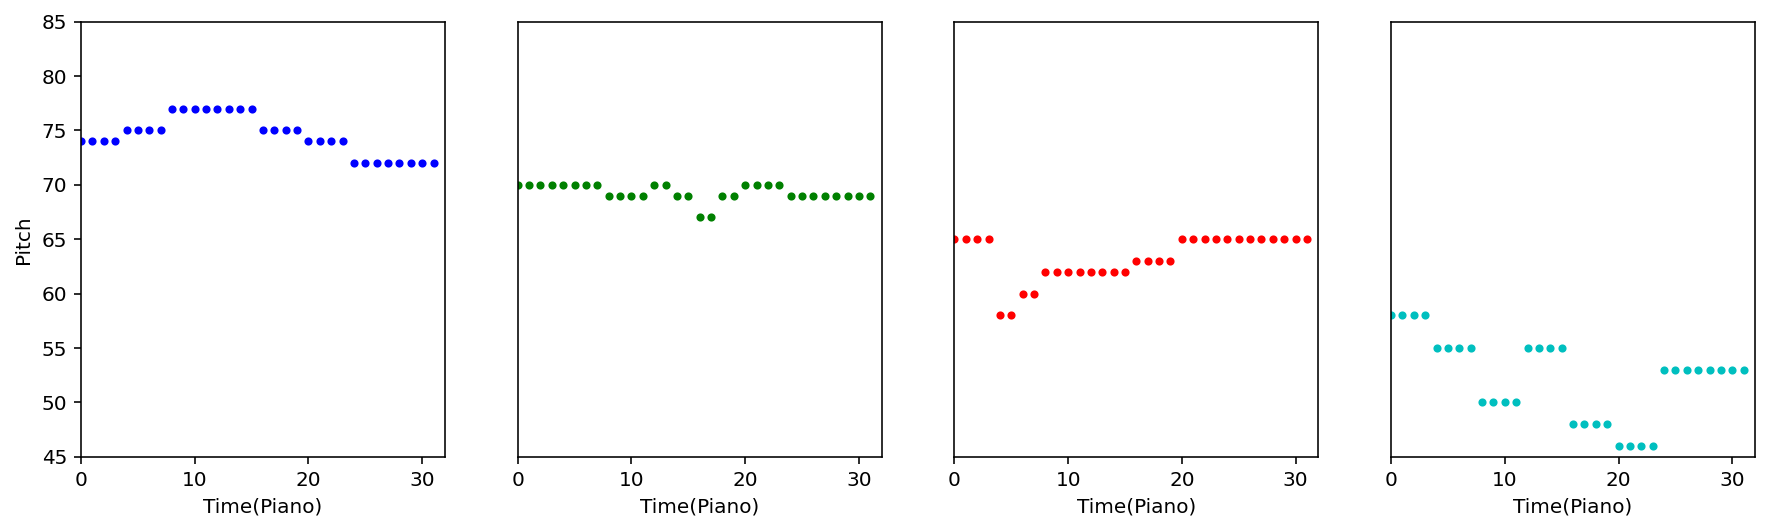

In [8]:
display_utils.show_pianoroll(training_data)

### Load data 

We now create a Tensorflow dataset object from our numpy array to feed into our model. The dataset object helps us feed batches of data into our model. A batch is a subset of the data that is passed through the deep learning network before the weights are updated. Batching data is necessary in most training scenarios as our training environment might not be able to load the entire dataset into memory at once.

In [12]:
#Number of input data samples in a batch
BATCH_SIZE = 64

#Shuffle buffer size for shuffling data
SHUFFLE_BUFFER_SIZE = 1000

#Preloads PREFETCH_SIZE batches so that there is no idle time between batches
PREFETCH_SIZE = 4

In [13]:
def prepare_dataset(filename):
    
    """Load the samples used for training."""
    
    data = np.load(filename)
    data = np.asarray(data, dtype=np.float32)  # {-1, 1}

    print('data shape = {}'.format(data.shape))

    dataset = tf.data.Dataset.from_tensor_slices(data)
    dataset = dataset.shuffle(SHUFFLE_BUFFER_SIZE).repeat()
    dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
    dataset = dataset.prefetch(PREFETCH_SIZE)

    return dataset 

dataset = prepare_dataset('./dataset/train.npy')

data shape = (229, 32, 128, 4)


## Model architecture
In this section, we will walk through the architecture of the proposed GAN.

The model consists of two networks, a generator and a critic. These two networks work in a tight loop as following:

* Generator:
    1. The generator takes in a batch of single-track piano rolls (melody) as the input and generates a batch of multi-track piano rolls as the output by adding accompaniments to each of the input music tracks. 
    2. The critic then takes these generated music tracks and predicts how far it deviates from the real data present in your training dataset.
    3. This feedback from the critic is used by the generator to update its weights.
* Critic: As the generator gets better at creating better music accompaniments using the feedback from the critic, the critic needs to be retrained as well.
    1. Train the critic with the music tracks just generated by the generator as fake inputs and an equivalent number of songs from the original dataset as the real input. 
* Alternate between training these two networks until the model converges and produces realistic music, beginning with the critic on the first iteration.

We use a special type of GAN called the **Wasserstein GAN with Gradient Penalty** (or **WGAN-GP**) to generate music. While the underlying architecture of a WGAN-GP is very similar to vanilla variants of GAN, WGAN-GPs help overcome some of the commonly seen defects in GANs such as the vanishing gradient problem and mode collapse (see appendix for more details).

Note our "critic" network is more generally called a "discriminator" network in the more general context of vanilla GANs.

### Generator

The generator is adapted from the U-Net architecture (a popular CNN that is used extensively in the computer vision domain), consisting of an “encoder” that maps the single track music data (represented as piano roll images) to a relatively lower dimensional “latent space“ and a ”decoder“ that maps the latent space back to multi-track music data.

Here are the inputs provided to the generator:

**Single-track piano roll input**: A single melody track of size (32, 128, 1) => (TimeStep, NumPitches, NumTracks) is provided as the input to the generator. 

**Latent noise vector**: A latent noise vector z of dimension (2, 8, 512) is also passed in as input and this is responsible for ensuring that there is a distinctive flavor to each output generated by the generator, even when the same input is provided.

Notice from the figure below that the encoding layers of the generator on the left side and decoder layer on on the right side are connected to create a U-shape, thereby giving the name U-Net to this architecture.

<img src="images/dgen.png" alt="Generator architecture" width="800">

In this implementation, we build the generator following a simple four-level Unet architecture by combining `_conv2d`s and `_deconv2d`, where `_conv2d` compose the contracting path and `_deconv2d` forms the expansive path. 

In [14]:
def _conv2d(layer_input, filters, f_size=4, bn=True):
    """Generator Basic Downsampling Block"""
    d = tf.keras.layers.Conv2D(filters, kernel_size=f_size, strides=2,
                               padding='same')(layer_input)
    d = tf.keras.layers.LeakyReLU(alpha=0.2)(d)
    if bn:
        d = tf.keras.layers.BatchNormalization(momentum=0.8)(d)
    return d


def _deconv2d(layer_input, pre_input, filters, f_size=4, dropout_rate=0):
    """Generator Basic Upsampling Block"""
    u = tf.keras.layers.UpSampling2D(size=2)(layer_input)
    u = tf.keras.layers.Conv2D(filters, kernel_size=f_size, strides=1,
                               padding='same')(u)
    u = tf.keras.layers.BatchNormalization(momentum=0.8)(u)
    u = tf.keras.layers.ReLU()(u)

    if dropout_rate:
        u = tf.keras.layers.Dropout(dropout_rate)(u)
        
    u = tf.keras.layers.Concatenate()([u, pre_input])
    return u

    
def build_generator(condition_input_shape=(32, 128, 1), filters=64,
                    instruments=4, latent_shape=(2, 8, 512)):
    """Buld Generator"""
    c_input = tf.keras.layers.Input(shape=condition_input_shape)
    z_input = tf.keras.layers.Input(shape=latent_shape)

    d1 = _conv2d(c_input, filters, bn=False)
    d2 = _conv2d(d1, filters * 2)
    d3 = _conv2d(d2, filters * 4)
    d4 = _conv2d(d3, filters * 8)

    d4 = tf.keras.layers.Concatenate(axis=-1)([d4, z_input])

    u4 = _deconv2d(d4, d3, filters * 4)
    u5 = _deconv2d(u4, d2, filters * 2)
    u6 = _deconv2d(u5, d1, filters)

    u7 = tf.keras.layers.UpSampling2D(size=2)(u6)
    output = tf.keras.layers.Conv2D(instruments, kernel_size=4, strides=1,
                               padding='same', activation='tanh')(u7)  # 32, 128, 4

    generator = tf.keras.models.Model([c_input, z_input], output, name='Generator')

    return generator

Let us now dive into each layer of the generator to see the inputs/outputs at each layer.

In [15]:
# Models
generator = build_generator()
generator.summary()

Model: "Generator"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 128, 1)] 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 16, 64, 64)   1088        input_1[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 16, 64, 64)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 8, 32, 128)   131200      leaky_re_lu[0][0]                
__________________________________________________________________________________________

### Critic (Discriminator)

The goal of the critic is to provide feedback to the generator about how realistic the generated piano rolls are, so that the generator can learn to produce more realistic data. The critic provides this feedback by outputting a scalar that  represents how “real” or “fake” a piano roll is.

Since the critic tries to classify data as “real” or “fake”, it is not very different from commonly used binary classifiers.  We use a simple architecture for the critic, composed of four convolutional layers and a dense layer at the end.

<img src="images/ddis.png" alt="Discriminator architecture" width="800">

In [16]:
def _build_critic_layer(layer_input, filters, f_size=4):
    """
    This layer decreases the spatial resolution by 2:

        input:  [batch_size, in_channels, H, W]
        output: [batch_size, out_channels, H/2, W/2]
    """
    d = tf.keras.layers.Conv2D(filters, kernel_size=f_size, strides=2,
                               padding='same')(layer_input)
    # Critic does not use batch-norm
    d = tf.keras.layers.LeakyReLU(alpha=0.2)(d) 
    return d


def build_critic(pianoroll_shape=(32, 128, 4), filters=64):
    """WGAN critic."""
    
    condition_input_shape = (32,128,1)
    groundtruth_pianoroll = tf.keras.layers.Input(shape=pianoroll_shape)
    condition_input = tf.keras.layers.Input(shape=condition_input_shape)
    combined_imgs = tf.keras.layers.Concatenate(axis=-1)([groundtruth_pianoroll, condition_input])


    
    d1 = _build_critic_layer(combined_imgs, filters)
    d2 = _build_critic_layer(d1, filters * 2)
    d3 = _build_critic_layer(d2, filters * 4)
    d4 = _build_critic_layer(d3, filters * 8)

    x = tf.keras.layers.Flatten()(d4)
    logit = tf.keras.layers.Dense(1)(x)

    critic = tf.keras.models.Model([groundtruth_pianoroll,condition_input], logit,
                                          name='Critic')
    

    return critic

In [17]:
# Create the Discriminator

critic = build_critic()
critic.summary() # View discriminator architecture.

Model: "Critic"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 32, 128, 4)] 0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 32, 128, 1)] 0                                            
__________________________________________________________________________________________________
concatenate_4 (Concatenate)     (None, 32, 128, 5)   0           input_3[0][0]                    
                                                                 input_4[0][0]                    
__________________________________________________________________________________________________
conv2d_8 (Conv2D)               (None, 16, 64, 64)   5184        concatenate_4[0][0]         

## Training

We train our models by searching for model parameters which optimize an objective function. For our WGAN-GP, we have special loss functions that we minimize as we alternate between training our generator and critic networks:

*Generator Loss:*
* We use the Wasserstein (Generator) loss function which is negative of the Critic Loss function. The generator is trained to bring the generated pianoroll as close to the real pianoroll as possible.
    * $\frac{1}{m} \sum_{i=1}^{m} -D_w(G(z^{i}|c^{i})|c^{i})$

*Critic Loss:*

* We begin with the Wasserstein (Critic) loss function designed to maximize the distance between the real piano roll distribution and generated (fake) piano roll distribution.
    * $\frac{1}{m} \sum_{i=1}^{m} [D_w(G(z^{i}|c^{i})|c^{i}) - D_w(x^{i}|c^{i})]$

* We add a gradient penalty loss function term designed to control how the gradient of the critic with respect to its input behaves.  This makes optimization of the generator easier. 
    * $\frac{1}{m} \sum_{i=1}^{m}(\lVert \nabla_{\hat{x}^i}D_w(\hat{x}^i|c^{i}) \rVert_2 -  1)^2 $

In [18]:
# Define the different loss functions

def generator_loss(critic_fake_output):
    """ Wasserstein GAN loss
    (Generator)  -D(G(z|c))
    """
    return -tf.reduce_mean(critic_fake_output)


def wasserstein_loss(critic_real_output, critic_fake_output):
    """ Wasserstein GAN loss
    (Critic)  D(G(z|c)) - D(x|c)
    """
    return tf.reduce_mean(critic_fake_output) - tf.reduce_mean(
        critic_real_output)


def compute_gradient_penalty(critic, x, fake_x):
    
    c = tf.expand_dims(x[..., 0], -1)
    batch_size = x.get_shape().as_list()[0]
    eps_x = tf.random.uniform(
        [batch_size] + [1] * (len(x.get_shape()) - 1))  # B, 1, 1, 1, 1
    inter = eps_x * x + (1.0 - eps_x) * fake_x

    with tf.GradientTape() as g:
        g.watch(inter)
        disc_inter_output = critic((inter,c), training=True)
    grads = g.gradient(disc_inter_output, inter)
    slopes = tf.sqrt(1e-8 + tf.reduce_sum(
        tf.square(grads),
        reduction_indices=tf.range(1, grads.get_shape().ndims)))
    gradient_penalty = tf.reduce_mean(tf.square(slopes - 1.0))
    
    return gradient_penalty


With our loss functions defined, we associate them with Tensorflow optimizers to define how our model will search for a good set of model parameters. We use the *Adam* algorithm, a commonly used general-purpose optimizer. We also set up checkpoints to save our progress as we train.

In [19]:
# Setup Adam optimizers for both G and D
generator_optimizer = tf.keras.optimizers.Adam(1e-3, beta_1=0.5, beta_2=0.9)
critic_optimizer = tf.keras.optimizers.Adam(1e-3, beta_1=0.5, beta_2=0.9)

# We define our checkpoint directory and where to save trained checkpoints
ckpt = tf.train.Checkpoint(generator=generator,
                           generator_optimizer=generator_optimizer,
                           critic=critic,
                           critic_optimizer=critic_optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, check_dir, max_to_keep=5)

Now we define the `generator_train_step` and `critic_train_step` functions, each of which performs a single forward pass on a batch and returns the corresponding loss.

In [20]:
@tf.function
def generator_train_step(x, condition_track_idx=0):

    ############################################
    #(1) Update G network: maximize D(G(z|c))
    ############################################

    # Extract condition track to make real batches pianoroll
    c = tf.expand_dims(x[..., condition_track_idx], -1)

    # Generate batch of latent vectors
    z = tf.random.truncated_normal([BATCH_SIZE, 2, 8, 512])

    with tf.GradientTape() as tape:
        fake_x = generator((c, z), training=True)
        fake_output = critic((fake_x,c), training=False)

        # Calculate Generator's loss based on this generated output
        gen_loss = generator_loss(fake_output)

    # Calculate gradients for Generator
    gradients_of_generator = tape.gradient(gen_loss,
                                           generator.trainable_variables)
    # Update Generator
    generator_optimizer.apply_gradients(
        zip(gradients_of_generator, generator.trainable_variables))

    return gen_loss


In [21]:
@tf.function
def critic_train_step(x, condition_track_idx=0):

    ############################################################################
    #(2) Update D network: maximize (D(x|c)) + (1 - D(G(z|c))|c) + GradientPenality() 
    ############################################################################

    # Extract condition track to make real batches pianoroll
    c = tf.expand_dims(x[..., condition_track_idx], -1)

    # Generate batch of latent vectors
    z = tf.random.truncated_normal([BATCH_SIZE, 2, 8, 512])

    # Generated fake pianoroll
    fake_x = generator((c, z), training=False)


    # Update critic parameters
    with tf.GradientTape() as tape:
        real_output = critic((x,c), training=True)
        fake_output = critic((fake_x,c), training=True)
        critic_loss =  wasserstein_loss(real_output, fake_output)

    # Caculate the gradients from the real and fake batches
    grads_of_critic = tape.gradient(critic_loss,
                                               critic.trainable_variables)

    with tf.GradientTape() as tape:
        gp_loss = compute_gradient_penalty(critic, x, fake_x)
        gp_loss *= 10.0

    # Calculate the gradients penalty from the real and fake batches
    grads_gp = tape.gradient(gp_loss, critic.trainable_variables)
    gradients_of_critic = [g + ggp for g, ggp in
                                  zip(grads_of_critic, grads_gp)
                                  if ggp is not None]

    # Update Critic
    critic_optimizer.apply_gradients(
        zip(gradients_of_critic, critic.trainable_variables))

    return critic_loss + gp_loss


Before we begin training, let's define some training configuration parameters and prepare to monitor important quantities. Here we log the losses and metrics which we can use to determine when to stop training. Consider coming back here to tweak these parameters and explore how your model responds. 

In [22]:
# We use load_melody_samples() to load 10 input data samples from our dataset into sample_x 
# and 10 random noise latent vectors into sample_z
sample_x, sample_z = inference_utils.load_melody_samples(n_sample=10)

Loaded 10 melody samples


In [23]:
# Number of iterations to train for
iterations = 1000

# Update critic n times per generator update 
n_dis_updates_per_gen_update = 5

# Determine input track in sample_x that we condition on
condition_track_idx = 0 
sample_c = tf.expand_dims(sample_x[..., condition_track_idx], -1)

Let us now train our model!

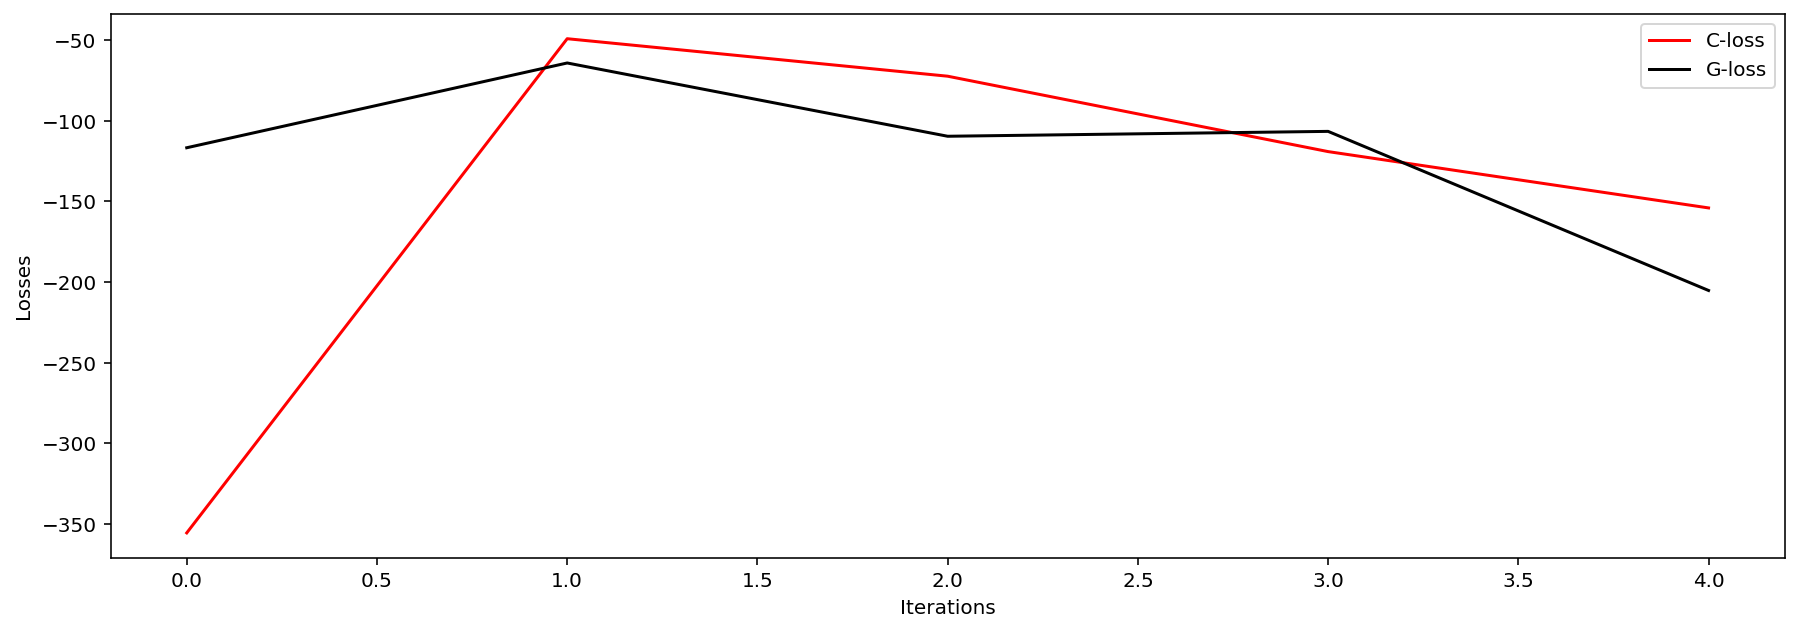

Iteration 4, c_loss=-154.11, g_loss=-205.28


In [ ]:
# Clear out any old metrics we've collected
metrics_utils.metrics_manager.initialize()

# Keep a running list of various quantities:
c_losses = []
g_losses = []

# Data iterator to iterate over our dataset
it = iter(dataset)

for iteration in range(iterations):

    # Train critic
    for _ in range(n_dis_updates_per_gen_update):
        c_loss = critic_train_step(next(it))

    # Train generator
    g_loss = generator_train_step(next(it))

    # Save Losses for plotting later
    c_losses.append(c_loss)
    g_losses.append(g_loss)

    display.clear_output(wait=True)
    fig = plt.figure(figsize=(15, 5))
    line1, = plt.plot(range(iteration+1), c_losses, 'r')
    line2, = plt.plot(range(iteration+1), g_losses, 'k')
    plt.xlabel('Iterations')
    plt.ylabel('Losses')
    plt.legend((line1, line2), ('C-loss', 'G-loss'))
    display.display(fig)
    plt.close(fig)
    
    # Output training stats
    print('Iteration {}, c_loss={:.2f}, g_loss={:.2f}'.format(iteration, c_loss, g_loss))
    
    # Save checkpoints, music metrics, generated output
    if iteration < 100 or iteration % 50 == 0 :
        # Check how the generator is doing by saving G's samples on fixed_noise
        fake_sample_x = generator((sample_c, sample_z), training=False)
        metrics_utils.metrics_manager.append_metrics_for_iteration(fake_sample_x.numpy(), iteration)

        if iteration % 50 == 0:
            # Save the checkpoint to disk.
            ckpt_manager.save(checkpoint_number=iteration) 
        
            fake_sample_x = fake_sample_x.numpy()
    
            # plot the pianoroll
            display_utils.plot_pianoroll(iteration, sample_x[:4], fake_sample_x[:4], save_dir=train_dir)

            # generate the midi
            destination_path = path_utils.generated_midi_path_for_iteration(iteration, saveto_dir=sample_dir)
            midi_utils.save_pianoroll_as_midi(fake_sample_x[:4], destination_path=destination_path)


### We have started training!

When using the Wasserstein loss function, we should train the critic to converge to ensure that the gradients for the generator update are accurate. This is in contrast to a standard GAN, where it is important not to let the critic get too strong, to avoid vanishing gradients.

Therefore, using the Wasserstein loss removes one of the key difficulties of training GANs—how to balance the training of the discriminator and generator. With WGANs, we can simply train the critic several times between generator updates, to ensure it is close to convergence. A typical ratio used is five critic updates to one generator update.

### "Babysitting" the learning process

Given that training these models can be an investment in time and resources, we must to continuously monitor training in order to catch and address anomalies if/when they occur. Here are some things to look out for:

**What should the losses look like?**

The adversarial learning process is highly dynamic and high-frequency oscillations are quite common. However if either loss (critic or generator) skyrockets to huge values, plunges to 0, or get stuck on a single value, there is likely an issue somewhere.

**Is my model learning?**
- Monitor the critic loss and other music quality metrics (if applicable). Are they following the expected trajectories?
- Monitor the generated samples (piano rolls). Are they improving over time? Do you see evidence of mode collapse? Have you tried listening to your samples?

**How do I know when to stop?**
- If the samples meet your expectations
- Critic loss no longer improving
- The expected value of the musical quality metrics converge to the corresponding expected value of the same metric on the training data

### How to measure sample quality during training 

Typically, when training any sort of neural networks, it is standard practice to monitor the value of the loss function throughout the duration of the training. The critic loss in WGANs has been found to correlate well with sample quality.

While standard mechanisms exist for evaluating the accuracy of more traditional models like classifiers or regressors, evaluating generative models is an active area of research. Within the domain of music generation, this hard problem is even less well-understood.

To address this, we take high-level measurements of our data and show how well our model produces music that aligns with those measurements. If our model produces music which is close to the mean value of these measurements for our training dataset, our music should match on general “shape”.

We’ll look at three such measurements:
- **Empty bar rate:** The ratio of empty bars to total number of bars.
- **Pitch histogram distance:** A metric that captures the distribution and position of pitches.
- **In Scale Ratio:** Ratio of the number of notes that are in C major key, which is a common key found in music, to the total number of notes. 


## Evaluate results

Now that we have finished training, let's find out how we did. We will analyze our model in several ways:
1. Examine how the generator and critic losses changed while training
2. Understand how certain musical metrics changed while training
3. Visualize generated piano roll output for a fixed input at every iteration and create a video


Let us first restore our last saved checkpoint. If you did not complete training but still want to continue with a pre-trained version, set `TRAIN = False`.

In [ ]:
ckpt = tf.train.Checkpoint(generator=generator)
ckpt_manager = tf.train.CheckpointManager(ckpt, check_dir, max_to_keep=5)

ckpt.restore(ckpt_manager.latest_checkpoint).expect_partial()
print('Latest checkpoint {} restored.'.format(ckpt_manager.latest_checkpoint))

### Plot losses

In [ ]:
display_utils.plot_loss_logs(g_losses, c_losses, figsize=(15, 5), smoothing=0.01)

Observe how the critic loss (C_loss in the graph) decays to zero as we train. In WGAN-GPs, the critic loss decreases (almost) monotonically as you train.

### Plot metrics

In [ ]:
metrics_utils.metrics_manager.set_reference_metrics(training_data)
metrics_utils.metrics_manager.plot_metrics()

Each row here corresponds to a different music quality metric and each column denotes an instrument track. 

Observe how the expected value of the different metrics (blue scatter) approach the corresponding training set expected values (red) as the number of iterations increase. You might expect to see diminishing returns as the model converges.


### Generated samples during training

The function below helps you probe intermediate samples generated in the training process. Remember that the conditioned input here is sampled from our training data. Let's start by listening to and observing a sample at iteration 0 and then iteration 100. Notice the difference!



In [ ]:
# Enter an iteration number (can be divided by 50) and listen to the midi at that iteration
iteration = 50
midi_file = os.path.join(sample_dir, 'iteration-{}.mid'.format(iteration))
display_utils.playmidi(midi_file)    

In [ ]:
# Enter an iteration number (can be divided by 50) and look at the generated pianorolls at that iteration
iteration = 50
pianoroll_png = os.path.join(train_dir, 'sample_iteration_%05d.png' % iteration)
display.Image(filename=pianoroll_png)

Let's see how the generated piano rolls change with the number of iterations.

In [ ]:
from IPython.display import Video


display_utils.make_training_video(train_dir)
video_path = "movie.mp4"
Video(video_path)

## Inference 

### Generating accompaniment for custom input

Congratulations! You have trained your very own WGAN-GP to generate music. Let us see how our generator performs on a custom input.

The function below generates a new song based on "Twinkle Twinkle Little Star".

In [ ]:
latest_midi = inference_utils.generate_midi(generator, eval_dir, input_midi_file='./input_twinkle_twinkle.mid')

In [ ]:
display_utils.playmidi(latest_midi)

We can also take a look at the generated piano rolls for a certain sample, to see how diverse they are!

In [ ]:
inference_utils.show_generated_pianorolls(generator, eval_dir, input_midi_file='./input_twinkle_twinkle.mid')

# What's next?

### Using your own data  (Optional)



To create your own dataset you can extract the piano roll from MIDI data. An example of creating a piano roll from a MIDI file is given below

In [ ]:
import numpy as np
from pypianoroll import Multitrack

midi_data = Multitrack('./input_twinkle_twinkle.mid')
tracks = [track.pianoroll for track in midi_data.tracks]
sample = np.stack(tracks, axis=-1)

print(sample.shape)

# Appendix

### Open source implementations
For more open-source implementations of generative models for music, check out:

- [MuseGAN](https://github.com/salu133445/musegan): Official TensorFlow Implementation that uses GANs to generate multi track polyphonic music
- [GANSynth](https://github.com/tensorflow/magenta/tree/master/magenta/models/gansynth): GANSynth uses a Progressive GAN architecture to incrementally upsample with convolution from a single vector to the full audio spectrogram
- [Music Transformer](https://github.com/tensorflow/magenta/tree/master/magenta/models/score2perf): Uses transformers to generate music!

GANs have also achieved state of the generative modeling in several other domains including cross domain image tranfer, celebrity face generation, super resolution text to image and image inpainting.

- [Keras-GAN](https://github.com/eriklindernoren/Keras-GAN): Library of reference implementations in Keras for image generation(good for educational purposes).

There's an ocean of literatures out there that use GANs for modeling distributions across fields! If you are interested, [Gan Zoo](https://github.com/hindupuravinash/the-gan-zoo) is a good place to start.

### References
<a id='references'></a>
1. [Dong, H.W., Hsiao, W.Y., Yang, L.C. and Yang, Y.H., 2018, April. MuseGAN: Multi-track sequential generative adversarial networks for symbolic music generation and accompaniment. In Thirty-Second AAAI Conference on Artificial Intelligence.](https://arxiv.org/abs/1709.06298)
2. [Ishaan, G., Faruk, A., Martin, A., Vincent, D. and Aaron, C., 2017. Improved training of wasserstein gans. In Advances in Neural Information Processing Systems.](https://arxiv.org/abs/1704.00028)
3. [Arjovsky, M., Chintala, S. and Bottou, L., 2017. Wasserstein gan. arXiv preprint arXiv:1701.07875.](https://arxiv.org/abs/1701.07875)
4. [Foster, D., 2019. Generative Deep Learning: Teaching Machines to Paint, Write, Compose, and Play. O'Reilly Media.](https://www.amazon.com/Generative-Deep-Learning-Teaching-Machines/dp/1492041947)

### More on Wassertein GAN with Gradient Penalty (optional)

While GANs are a major breakthrough for generative modeling, plain GANs are also notoriously difficult to train. Some common problems encountered are:

* **Oscillating loss:** The loss of the discriminator and generator can start to oscillate without exhibiting any long term stability.
* **Mode collapse:**  The generator may get stuck on a small set of samples that always fool the discriminator. This reduces the capability of the network to produce novel samples.
* **Uninformative loss:** The lack of correlation between the generator loss and quality of generated output makes plain GAN training difficult to interpret.


The [Wasserstein GAN](#references) was a major advancement in GANs and helped mitigate to some of these issues. Some of its features are:

1. It significantly improves the interpretability of loss functions and provides clearer stopping criteria
2. WGANs generally produce results of higher quality (demonstrated within the image generation domain)

**Mathematics of Wasserstein GAN with Gradient Penalty**

The [Wasserstein distance](https://en.wikipedia.org/wiki/Wasserstein_metric) between the true distribution $P_r$ and generated piano roll distribution $P_g$ is defined as follows:

$$\mathbb{W}(P_{r},P_{g})=\sup_{\lVert{f} \rVert_{L} \le 1} \mathbb{E}_{x \sim \mathbb{P}_r}(f(x)) - \mathbb{E}_{x \sim \mathbb{P}_g}(f(x)) $$

In this equation we are trying to minimize the distance between the expectation of the real distribution and the expectation of the generation distribution. $f$ is subject to a technical constraint in that it must be [1-Lipschitz](https://en.wikipedia.org/wiki/Lipschitz_continuity).

To enforce the 1-Lipschitz condition that basically constraints the gradients from varying too rapidly we use the gradient penalty.

**Gradient penalty**: We want to penalize the gradients of the critic. We implicitly define $P_{\hat{x}}$ by sampling uniformly along straight lines between pairs of points sampled from the data distribution $P_r$ and the generator distribution $P_g$.   This was originally motivated by the fact that the optimal critic contains straight lines with gradient norm 1 connecting coupled points from $P_r$ and $P_g$. We use a penalty coefficient $\lambda$= 10 as was recommended in the original paper. 

The loss with gradient penalty is:

$$\mathbb{L}(P_{r},P_{g},P_{\hat{x}} )= \mathbb{W}(P_{r},P_{g}) + \lambda \mathbb{E}_{\hat{x} \sim \mathbb{P}_\hat{x}}[(\lVert \nabla_{\hat{x}}D(\hat{x}) \rVert_2 -  1)^2]$$
|
This loss can be parametrized in terms of $w$ and $\theta$. We then use neural networks to learn the functions $f_w$ (discriminator) and  $g_\theta$ (generator).
$$\mathbb{W}(P_{r},P_{\theta})=\max_{w \in \mathbb{W}} \mathbb{E}_{x \sim \mathbb{P}_r}(D_w(x)) - \mathbb{E}_{z \sim p(z)}(D_w(G_{\theta}(z)) $$
$$\mathbb{L}(P_{r},P_{\theta},P_{\hat{x}})=\max_{w \in \mathbb{W}} \mathbb{E}_{x \sim \mathbb{P}_r}(D_w(x)) - \mathbb{E}_{z \sim p(z)}(D_w(G_{\theta}(z)) + \lambda \mathbb{E}_{\hat{x} \sim \mathbb{P}_\hat{x}}[(\lVert \nabla_{\hat{x}}D_w(\hat{x}) \rVert_2 -  1)^2]$$

where $$ \hat{x} = \epsilon x + (1- \epsilon) G(z) $$ and $$\epsilon \sim Unif(0,1)$$

The basic procedure to train is as following: 
1. We draw real_x from the real distribution $P_r$ and fake_x from the generated distribution $G_{\theta}(z)$ where $z \sim p(z)$
2. The latent vectors are sampled from z and then tranformed using the generator $G_{\theta}$ to get the fake samples fake_x. They are evaluated using the critic function $D_w$
3. We are trying to minimize the Wasserstein distance between the two distributions

Both the generator and critic are conditioned on the input pianoroll melody.